In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import random_split

c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load Data

In [3]:
dataset = load_dataset(path=r"C:\Users\mlfav\lib\shlee\Favorfit-Color-Recommendation\color_classification\Classification", split="train")
dataset.set_format(type="torch", columns=["input_data", "output_color"], dtype=torch.float32)
print(f"data: {dataset.shape}, version: {dataset.version}")

data: (72030, 2), version: 1.1.1


c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\datasets\load.py:922: FutureWarning: The repository for Classification contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at C:\Users\mlfav\lib\shlee\Favorfit-Color-Recommendation\color_classification\Classification\Classification.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
total_size = len(dataset)
train_size = int(total_size * 0.7)
valid_size = total_size - train_size
train_data, valid_data = random_split(dataset, [train_size, valid_size])
f"train_size: {train_size}, valid_size: {valid_size}"

'train_size: 50421, valid_size: 21609'

In [5]:
num_of_classes = 540
batch_size = 4

In [6]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [7]:
sample = train_loader.__iter__().__next__()
input_size = sample['input_data'].shape[1]
input_size

119

In [8]:
import json

weight_path = r"C:\Users\mlfav\lib\shlee\Favorfit-Color-Recommendation\color_classification\jsonl\class_weight.jsonl"
with open(weight_path, 'r') as path:
    class_weight = json.load(path)
class_weight = torch.tensor(class_weight, dtype=torch.float).to(device)

In [9]:
class_weight = 1/class_weight/10

### Hyper parameters

In [10]:
epochs = 3000
learning_rate = 0.001
alpha = 1

In [11]:
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="color_harmony",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "Classification",
    "dataset": "Classification",
    "epochs": epochs,
    "alpha": alpha,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lifethis21 (color_harmony). Use `wandb login --relogin` to force relogin


### Model

In [12]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.layer1 = nn.Linear(in_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, in_dim)
    
    def forward(self, x):
        residue = x
        x = self.layer1(x)
        x = self.layer2(x)
        return x + residue
    
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.seq_modules = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            ResBlock(1024, 2048),
            nn.LayerNorm(1024),
            nn.ReLU(),
            ResBlock(1024, 2048)
        )

        self.out = nn.Linear(1024, 540)

    def forward(self, x):
        x = self.seq_modules(x)
        x = self.out(x)
        return x

In [13]:
def variance_sensitive_crossentropy_loss(h, h_label, y):
    cross_entropy = nn.CrossEntropyLoss()
    ce_loss = cross_entropy(h, y)

    num_unique = len(torch.unique(h_label))
    return ce_loss + alpha * (1/num_unique - 1/4)*4**2

In [14]:
model = Classification().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
from custom_lr_scheduler import CosineAnnealingWarmUpRestarts

scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=20, T_mult=2, eta_max=learning_rate,  T_up=3, gamma=0.5)

In [15]:
from tqdm import tqdm


def train(train_loader):
    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    model.train()
    for data in tqdm(train_loader, total=len(train_loader), leave=False):
        x = data['input_data'].to(device)
        y = data['output_color'].to(dtype=torch.int64)

        y_array = torch.eye(num_of_classes)[y].to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        
        _, top_predictions = torch.topk(output, k=4, dim=1)
        correct_predictions += torch.any(top_predictions.to("cpu") == y.view(-1, 1), dim=1).sum().item()
        
        loss = variance_sensitive_crossentropy_loss(output, top_predictions[:, 0], y_array)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        total_samples += y.size(0)

    accuracy = correct_predictions / total_samples * 100
    average_loss = train_loss / len(train_loader)

    return average_loss, accuracy


def valid(valid_loader):
    valid_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for data in tqdm(valid_loader, total=len(valid_loader), leave=False):
            x = data['input_data'].to(device)
            y = data['output_color'].to(dtype=torch.int64)

            y_array = torch.eye(num_of_classes)[y].to(device)

            output = model.forward(x)
            
            _, top_predictions = torch.topk(output, k=4, dim=1)
            correct_predictions += torch.any(top_predictions.to("cpu") == y.view(-1, 1), dim=1).sum().item()

            loss = variance_sensitive_crossentropy_loss(output, top_predictions[:, 0], y_array)
            
            valid_loss += loss.item()

            total_samples += y.size(0)

    accuracy = correct_predictions / total_samples * 100
    average_loss = valid_loss / len(valid_loader)

    return average_loss, accuracy


In [16]:
for epoch in range(epochs):
    t_loss, t_acc = train(train_loader)
    v_loss, v_acc = valid(valid_loader)
    scheduler.step()
    
    wandb.log({"epoch": epoch, "learning rate": optimizer.param_groups[0]['lr'], "train loss": t_loss, "train accuracy": t_acc, "valid loss": v_loss, "valid accuracy": v_acc})

KeyboardInterrupt: 

In [25]:
model.eval()

with torch.no_grad():
    sample = train_loader.__iter__().__next__()
    x = sample['input_data'].to(device)
    label = sample['output_color']

    output = model.forward(x)

    _, output_index = torch.max(output, 1)

    _, top_predictions = torch.topk(output, k=4, dim=1)
    print(f"output: {output_index}")
    print(f"top_predictions: {top_predictions}, label: {label}")

output: tensor([216, 331,  57,  39], device='cuda:0')
top_predictions: tensor([[216, 310, 333, 322],
        [331, 165, 199, 252],
        [ 57, 144, 163, 111],
        [ 39,   4, 406,  47]], device='cuda:0'), label: tensor([216., 331.,  57.,  39.])


In [18]:
import json

list_of_colors_path = r'C:\Users\mlfav\lib\shlee\Favorfit-Color-Recommendation\color_classification\jsonl\list_of_colors.jsonl'
with open(list_of_colors_path, 'r') as list_of_colors_file:
    list_of_colors_data = [json.loads(line) for line in list_of_colors_file]

list_of_colors = [data['color_rgb'] for data in list_of_colors_data]

In [19]:
for i in range(batch_size):
    prediction_colors = [list_of_colors[c] for c in top_predictions[i]]
    print(prediction_colors)



[[210, 180, 140], [160, 120, 90], [193, 154, 107], [239, 223, 187]]
[[230, 230, 250], [247, 247, 247], [185, 217, 235], [190, 191, 197]]
[[219, 215, 210], [192, 192, 192], [85, 85, 85], [65, 74, 76]]
[[0, 73, 83], [0, 35, 102], [0, 33, 71], [255, 117, 24]]


모델 출력: 216 label: 216
모델 출력: 331 label: 331
모델 출력: 57 label: 57
모델 출력: 39 label: 39


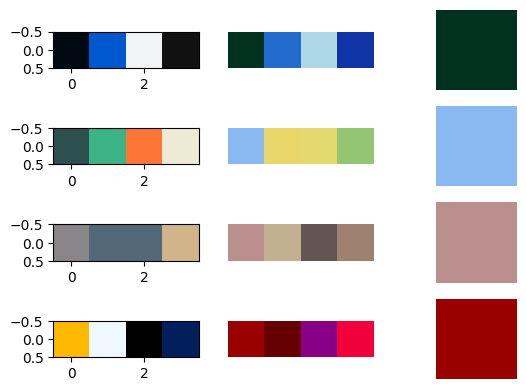

In [26]:
import matplotlib.pyplot as plt

for i in range(batch_size):
    x_tmp = x[i][:12].cpu().detach().numpy().reshape((4,3))
    label_tmp = list_of_colors[int(label.numpy()[i])]
    output_tmp = list_of_colors[output_index[i]]

    plt.subplot(batch_size, 3, i * 3 + 1)
    plt.imshow([x_tmp])

    plt.subplot(batch_size, 3, i * 3 + 2)
    # plt.imshow([[output_tmp]])
    prediction_colors = [list_of_colors[c] for c in top_predictions[i]]
    plt.imshow([prediction_colors])
    plt.axis(False)

    plt.subplot(batch_size, 3, i * 3 + 3)
    plt.imshow([[label_tmp]])
    plt.axis(False)

    print("모델 출력:", output_index[i].item(), "label:", int(label.numpy()[i]))

In [28]:
PATH = r'C:\Users\mlfav\lib\shlee\Favorfit-Color-Recommendation\Model/model.pt'
torch.save(model.state_dict(), PATH)

In [29]:
model

Classification(
  (seq_modules): Sequential(
    (0): Linear(in_features=119, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ResBlock(
      (layer1): Linear(in_features=1024, out_features=2048, bias=True)
      (layer2): Linear(in_features=2048, out_features=1024, bias=True)
    )
    (8): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (9): ReLU()
    (10): ResBlock(
      (layer1): Linear(in_features=1024, out_features=2048, bias=True)
      (layer2): Linear(in_features=2048, out_features=1024, bias=True)
    )
  )
  (out): Linear(in_features=1024, out_features=540, bias=True)
)